# Study-case: Shazam
This tutorial is based on Laboratory No. 2, Princeton ELE 201, Spring 2014, by Paul W. Cuff and the paper Wang, A. (2003, October). An industrial strength audio search algorithm. In Ismir (Vol. 2003, pp. 7-13).

Datasets: 
* Music Dataset: https://github.com/mdeff/fma 
* Hash tables: https://drive.google.com/drive/folders/1BXF7C5Ncqdanj3fTHF5hb84TjBdrzdhH?usp=sharing 


In this section of the tutorial, we will create a basic music recognition application based on the paper "An Industrial-Strength Audio Search Algorithm." In the first part, we will discuss the fundamentals of creating song fingerprints and constructing a dataset of hash tables for an entire playlist. In the second part, we will explore how to identify a song using only seven seconds of recorded music and the fingerprint dataset.

## Part 1: Create Database

In this section, we will discuss how to create a song's fingerprint based on the peaks of its spectrogram. The following figure illustrates the spectrogram of a song alongside a constellation map, which represents key power patterns in the spectrogram.

![shazam](img/shazam.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import soundfile as sf
import librosa as lr
import pickle
import IPython.display as ipd
from heapq import heappush, heappushpop
from collections import Counter, defaultdict
from pathlib import Path

plt.rcParams['figure.figsize'] = (17, 5)

### Load and Preprocess Database of Songs

In [2]:
# Load the metadata from zip file
tracks_df = pd.read_csv('data/fma_metadata/raw_tracks.csv')

# Keep only the columns we need: track_id, track_title, artist_name, album_title
tracks_df = tracks_df[['track_id', 'track_title', 'artist_name', 'album_title']]

# Print the first 5 rows of the tracks dataframe
tracks_df.head()

track_id      track_title artist_name           album_title
0         2             Food        AWOL  AWOL - A Way Of Life
1         3     Electric Ave        AWOL  AWOL - A Way Of Life
2         5       This World        AWOL  AWOL - A Way Of Life
3        10          Freeway   Kurt Vile     Constant Hitmaker
4        20  Spiritual Level  Nicky Cook                 Niris

### Explore Data and Make Spectrograms

   track_id track_title artist_name           album_title
0         2        Food        AWOL  AWOL - A Way Of Life


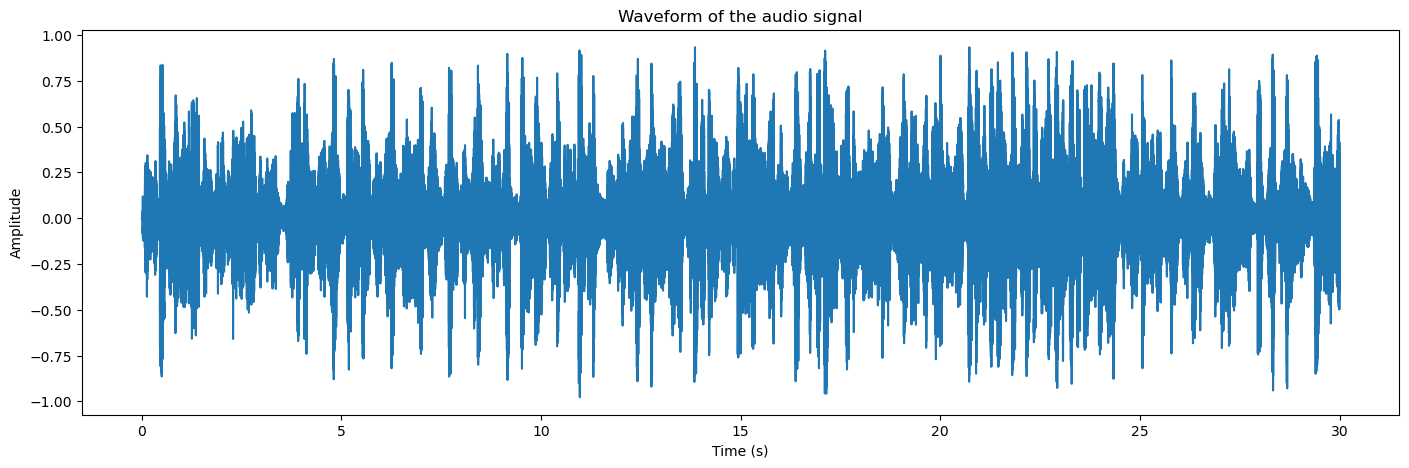

In [3]:
# Load one of the audio files
filename = 'data/fma_small/000/000002.mp3'
x, sr = lr.load(filename, sr=None, mono=True)
time = np.linspace(0, 30, len(x))

# Print the information of the song
print(tracks_df[tracks_df['track_id'] == 2])

# Plot the waveform of the audio signal
plt.plot(time, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of the audio signal')
plt.show()


In [4]:
# Play the audio file
ipd.Audio(data=x, rate=sr)

The **melspectrogram** of an audio signal is a representation of the power of the signal in different frequency bands as a function of time. It is computed by taking the **short-time Fourier transform** of the signal, mapping the power of the signal in each frequency band to the mel scale, and then taking the logarithm of the result. The **mel scale** is a perceptual scale of pitches that is based on the human ear's response to different frequencies. the relation  between herts into mels is given by the formula:
$$
mels = 2595 * \log_{10}(1 + hz / 700)
$$

In [5]:
# Compute the short-time Fourier transform (STFT)
stft = np.abs(lr.stft(x, n_fft=2048, hop_length=512))

# Convert the STFT to decibels
mel = lr.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = lr.power_to_db(mel, ref=np.max)

# Plot the mel spectrogram
lr.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()


As we do not need the entire spectrum to make a fingerprint, we can downsample the mel spectrogram to reduce the size of the fingerprint.

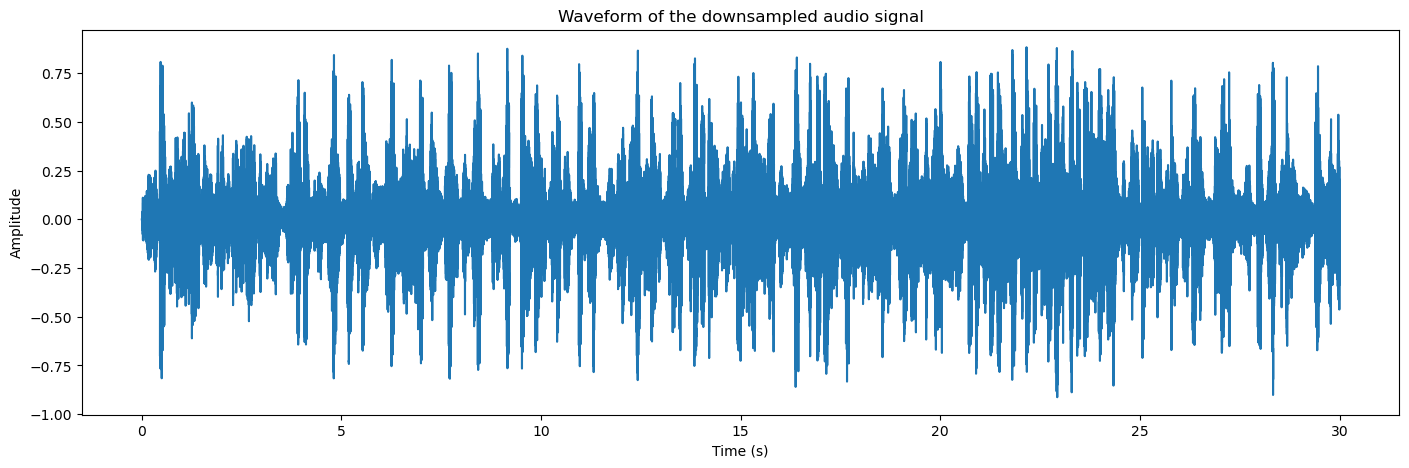

In [6]:
# Downsample the audio file
sr_downsample = 8000
x_downsampled = lr.resample(x, orig_sr = sr, target_sr = sr_downsample)
time_downsampled = np.linspace(0, 30, len(x_downsampled))

# Plot the waveform of the new audio signal
plt.plot(time_downsampled, x_downsampled)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of the downsampled audio signal')
plt.show()

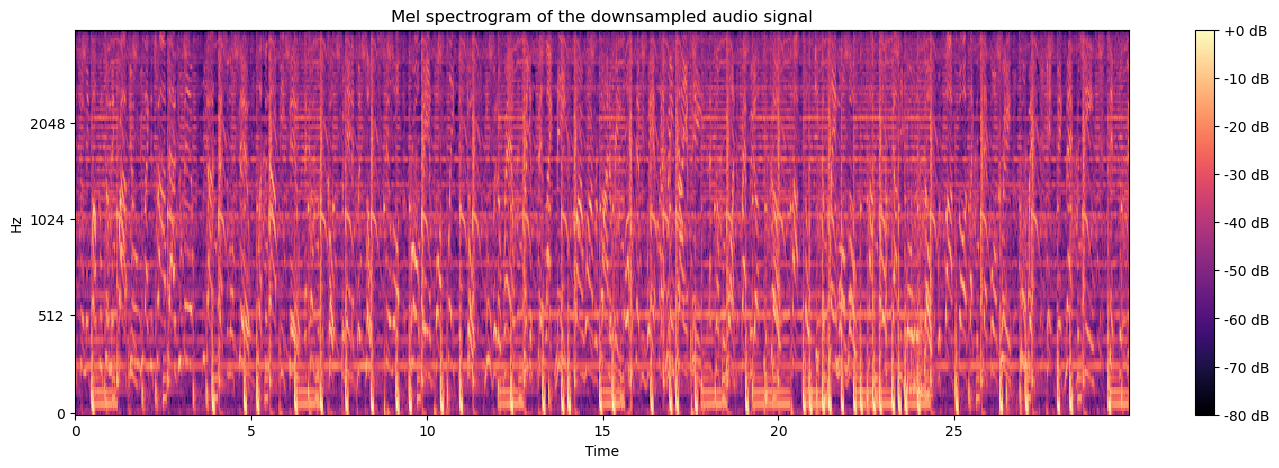

In [7]:
# Make melspectrogram of the downsampled audio signal

# Compute the short-time Fourier transform (STFT)
stft_downsampled = np.abs(lr.stft(x_downsampled, n_fft=2048, hop_length=512))

# Define window length and overlap in milliseconds
window_length_ms = 64
overlap_ms = 32

# Convert window length and overlap to samples
n_fft = int(sr_downsample * window_length_ms / 1000)
hop_length = int(sr_downsample * overlap_ms / 1000)

# Compute the short-time Fourier transform (STFT) with the new parameters
stft_downsampled = np.abs(lr.stft(x_downsampled, n_fft=n_fft, hop_length=hop_length))

# Convert the STFT to decibels
mel_downsampled = lr.feature.melspectrogram(sr=sr_downsample, S=stft_downsampled**2)
log_mel_downsampled = lr.power_to_db(mel_downsampled, ref=np.max)

# Plot the mel spectrogram
lr.display.specshow(log_mel_downsampled, sr=sr_downsample, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram of the downsampled audio signal')
plt.show()


### Create Database of Constellation Maps (Song Fingerprints)

With the mel spectrogram of the downsampled audio signal, we can now create the song's fingerprints. We will identify the local maxima of the mel spectrogram and use them as the fingerprints. We add a thresshold as well to keep significant peaks.


In [8]:
# Initialize peak detection parameters
size = 4          # Size of the local maximum filter
threshold = -30.0

# Apply maximum filter and find where it equals the original data
local_max = (log_mel_downsampled == maximum_filter(log_mel_downsampled, size=size)) & (log_mel_downsampled > threshold)

# Get peak positions and values
peak_positions = list(zip(*np.where(local_max)))
peak_values = [log_mel_downsampled[f, t] for f, t in peak_positions]

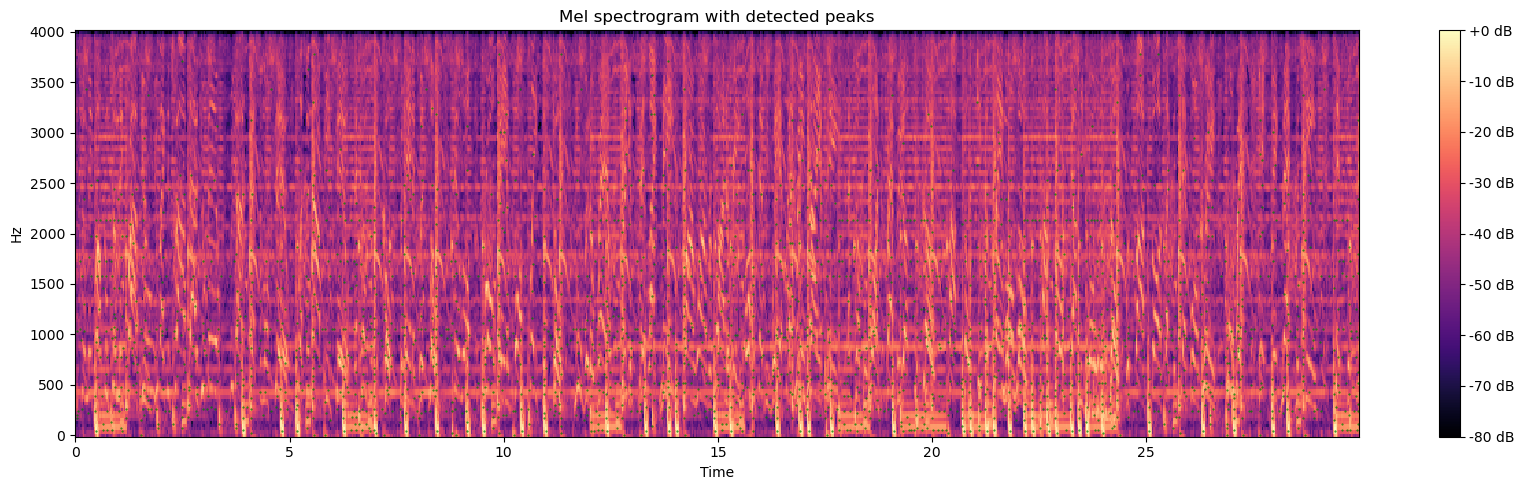

In [9]:
# Plot mel spectrogram using librosa's specshow
img = lr.display.specshow(log_mel_downsampled, 
                         sr=sr_downsample,
                         hop_length=hop_length,
                         x_axis='time',
                         y_axis='hz')

# Calculate frequencies for mel bands
n_mels = log_mel_downsampled.shape[0]
mel_freqs = lr.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr_downsample//2)

if peak_positions:
    peak_freq_idx, peak_time_idx = zip(*peak_positions)
    # Convert time indices to seconds
    peak_times = lr.frames_to_time(peak_time_idx, sr=sr_downsample, hop_length=hop_length)
    # Convert frequency indices to actual frequencies using mel scale
    peak_freqs = [mel_freqs[idx] for idx in peak_freq_idx]
    plt.plot(peak_times, peak_freqs, 'g.', markersize=1, alpha=0.9, label='Peaks')

plt.title('Mel spectrogram with detected peaks')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [10]:
# Create a binary image of peaks
peak_image = np.zeros_like(log_mel_downsampled)
peak_image[local_max] = 1

# Calculate axis values
time_axis = np.arange(log_mel_downsampled.shape[1]) * hop_length / sr_downsample

# Plot the fingerprint of the audio signal
plt.imshow(peak_image, 
          aspect='auto',
          origin='lower',
          extent=[time_axis[0], time_axis[-1], mel_freqs[0], mel_freqs[-1]],
          cmap='binary')  

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Peak Locations')
plt.show()

After detecting the song's peaks, we will pair those that are close to each other in both time and frequency to identify strong relationships within the spectrogram.

![peak-pairing](img/peak-pairing.png)

*Image from Laboratory No. 2, Princeton ELE 201, Spring 2014, by Paul W. Cuff*

In [11]:
# Set parameters for peak pairing
del_t = 35      # bound on time difference (in pixels)
del_f = 30      # bound on frequency difference (in pixels)
fanout = 3      # Maximum number of pairs per peak

# Get peak positions
f, t = np.where(local_max)
peak_count = len(f)

# Initialize array for pairs (maximum possible size)
tuple_list = []

# For each peak
for i in range(peak_count):
    links = 0
    
    # First look along frequency axis at same time
    for f2 in range(min(local_max.shape[0], f[i]+1), 
                    min(local_max.shape[0], f[i]+del_f+1)):
        if local_max[f2, t[i]]:
            tuple_list.append([t[i], t[i], f[i], f2])
            links += 1
            if links >= fanout:
                break
    
    # Then look at later times
    for t2 in range(min(local_max.shape[1], t[i]+1), 
                    min(local_max.shape[1], t[i]+del_t+1)):
        if links >= fanout:
            break
        for f2 in range(max(0, f[i]-del_f), 
                       min(local_max.shape[0], f[i]+del_f+1)):
            if links >= fanout:
                break
            if local_max[f2, t2]:
                tuple_list.append([t[i], t2, f[i], f2])
                links += 1

pairs = np.array(tuple_list)

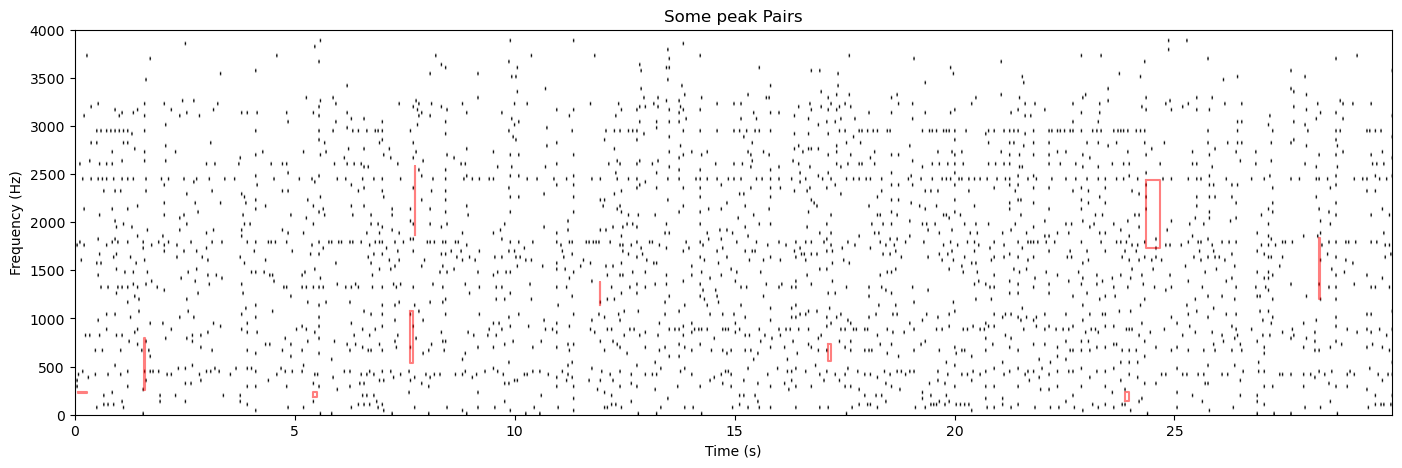

Total pairs found: 7404


In [12]:
# Plot random selection of pairs
plt.imshow(peak_image,
          aspect='auto',
          origin='lower',
          extent=[time_axis[0], time_axis[-1], mel_freqs[0], mel_freqs[-1]],
          cmap='binary')

# Plot 10 random pairs
rand_idx = np.random.choice(len(pairs), 10, replace=False)
for pair in pairs[rand_idx]:
    t1_sec = time_axis[int(pair[0])]
    t2_sec = time_axis[int(pair[1])]
    f1_hz = mel_freqs[int(pair[2])]
    f2_hz = mel_freqs[int(pair[3])]
    
    # Draw all four sides of the box
    plt.plot([t1_sec, t2_sec, t2_sec, t1_sec, t1_sec],
            [f1_hz, f1_hz, f2_hz, f2_hz, f1_hz],
            'r-', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Some peak Pairs')
plt.show()

print(f"Total pairs found: {len(pairs)}")

### Hash Tables 
We will store these peak pairs in hash tables. A hash table is a data structure that maps keys to values. In this case, the keys are derived from a function applied to each peak pair, and the values are lists of the first time indices corresponding to the peak pairs.

In [13]:
# Calculate hash values for peak pairs
size = 1000  # size of hash table
hash_table = {}

# Create hash function
def simple_hash(f1, f2, delta_t, size):
   hash_val = size * 1000000 * (np.log(abs(f1) + 2) + 
                               2 * np.log(abs(f2) + 2) + 
                               3 * np.log(abs(delta_t) + 2))
   return int(np.round(hash_val) % size)

# Create hashes from peak pairs
for t1, t2, f1, f2 in pairs:
   # Get frequencies and time difference
   f1_hz = int(mel_freqs[int(f1)])
   f2_hz = int(mel_freqs[int(f2)])
   delta_t = t2 - t1
   
   # Calculate hash
   hash_key = simple_hash(f1_hz, f2_hz, delta_t, size)
   
   # Store in hash table
   if hash_key not in hash_table:
       hash_table[hash_key] = []
   hash_table[hash_key].append(t1)

# Print some statistics
print(f"Number of pairs: {len(pairs)}")
print(f"Number of hash keys: {len(hash_table)}")
print(f"Hash table size: {size}")
print("\nExample hash entries:")
for key in list(hash_table.keys())[:5]:
   print(f"Hash key {key}: {len(hash_table[key])} time points")
   print(f"Time points: {hash_table[key]}")

Number of pairs: 7404
Number of hash keys: 996
Hash table size: 1000

Example hash entries:
Hash key 334: 10 time points
Time points: [48, 775, 748, 779, 921, 934, 176, 541, 658, 486]
Hash key 309: 4 time points
Time points: [48, 635, 433, 934]
Hash key 222: 7 time points
Time points: [48, 117, 212, 875, 63, 896, 196]
Hash key 821: 10 time points
Time points: [174, 209, 563, 565, 629, 231, 556, 128, 309, 670]
Hash key 445: 5 time points
Time points: [174, 535, 240, 287, 829]


## Part 2: Identify Songs

The process for identifying a song is as follows:
* Load the audio file fragment (10 seconds).
* Compute the mel spectrogram of the audio signal.
* Detect the peaks in the mel spectrogram.
* Pair the detected peaks to form time-frequency pairs.
* Calculate hash values for the pairs.
* Compare the hash values with those in the dataset.
* Identify the song with the highest number of matching hash values.

### Create and Preprocess Song Segment to Identify

In [14]:
# Load a random song from the dataset and cut it randomly to 10 seconds
testing_song = 'data/fma_small/089/089192.mp3'

x_test, sr = lr.load(testing_song, sr=None, mono=True)
start = np.random.randint(0, len(x_test) - sr * 10)
x_test_cut = x_test[start:start + sr * 10]

# Print the information of the song
print(tracks_df[tracks_df['track_id'] == 89192])


       track_id track_title artist_name      album_title
62305     89192  Raro Bueno   Chuzausen  Awesome Is Grey


In [15]:
# Play the fragment of the song
ipd.Audio(data=x_test_cut, rate=sr)

### Extract Fingerprints: Spectrogram -> Peak Pairs -> Hash Values

In [16]:
def process_song(audio_signal, sr=22050, sr_downsample=8000):  
    # Ensure mono
    if len(audio_signal.shape) > 1:
        audio_signal = np.mean(audio_signal, axis=1)
    
    # Downsample
    x_downsampled = lr.resample(audio_signal, orig_sr=sr, target_sr=sr_downsample)
    
    # Create mel spectrogram with same parameters as database
    window_length_ms = 64  # Match database
    overlap_ms = 32       # Match database
    n_fft = int(sr_downsample * window_length_ms / 1000)
    hop_length = int(sr_downsample * overlap_ms / 1000)
    
    stft_downsampled = np.abs(lr.stft(x_downsampled, n_fft=n_fft, hop_length=hop_length))
    
    mel_downsampled = lr.feature.melspectrogram(
        sr=sr_downsample, 
        S=stft_downsampled**2,
        n_mels=128,      # Fixed number of mel bands
        hop_length=hop_length
    )
    log_mel_downsampled = lr.power_to_db(mel_downsampled, ref=np.max)
    
    # Find peaks with same parameters as database
    size = 4             # Match database
    threshold = -30.0    # Match database
    local_max = (log_mel_downsampled == maximum_filter(log_mel_downsampled, size=size)) & \
                (log_mel_downsampled > threshold)
    
    # Create pairs with same parameters as database
    del_t = 35          # Match database
    del_f = 30          # Match database
    fanout = 3
    f, t = np.where(local_max)
    
    pairs = []
    
    # Find pairs using same logic as database
    for i in range(len(f)):
        links = 0
        f2_range = range(f[i]+1, min(f[i]+del_f+1, local_max.shape[0]))
        
        # Along frequency axis (match database logic)
        for f2 in f2_range:
            if local_max[f2, t[i]]:
                pairs.append([t[i], t[i], f[i], f2])
                links += 1
                if links >= fanout:
                    break
        
        # Along time axis (match database logic)
        if links < fanout:
            t2_range = range(t[i]+1, min(t[i]+del_t+1, local_max.shape[1]))
            f2_range = range(max(0, f[i]-del_f), min(f[i]+del_f+1, local_max.shape[0]))
            
            for t2 in t2_range:
                if links >= fanout:
                    break
                for f2 in f2_range:
                    if local_max[f2, t2]:
                        pairs.append([t[i], t2, f[i], f2])
                        links += 1
                        if links >= fanout:
                            break
    
    # Create hash table
    size = 1000
    hash_table = {}
    mel_freqs = lr.mel_frequencies(n_mels=log_mel_downsampled.shape[0], 
                                 fmin=0, 
                                 fmax=sr_downsample//2)
    
    # Create hashes from pairs
    for t1, t2, f1, f2 in pairs:
        f1_hz = int(mel_freqs[int(f1)])
        f2_hz = int(mel_freqs[int(f2)])
        delta_t = t2 - t1
        
        hash_val = size * 1000000 * (np.log(abs(f1_hz) + 2) + 
                                    2 * np.log(abs(f2_hz) + 2) + 
                                    3 * np.log(abs(delta_t) + 2))
        hash_key = int(np.round(hash_val) % size)
        
        if hash_key not in hash_table:
            hash_table[hash_key] = []
        hash_table[hash_key].append(t1)
    
    return hash_table, log_mel_downsampled, local_max

In [17]:
# Process the 5-second segment with debug info
query_hash, query_spec, query_peaks = process_song(x_test_cut, sr=sr)

# Print hash table info
print(f"\nNumber of hash keys: {len(query_hash)}")
print(f"Hash table keys: {list(query_hash.keys())[:5]}")


Number of hash keys: 777
Hash table keys: [614, 917, 933, 459, 889]


### Seach Segment within Database

In [18]:
def search_hash_tables(query_hash_table, database_path, threshold=5, top_k=5):
    # Load database and index
    with open(database_path, 'rb') as f:
        database = pickle.load(f)
    with open(database_path.replace('.pkl', '_index.pkl'), 'rb') as f:
        index = pickle.load(f)
    
    # First pass: collect all matches using inverted index
    track_matches = defaultdict(list)
    for hash_key, query_times in query_hash_table.items():
        if hash_key in index:
            for track_id, db_times in index[hash_key]:
                # Record all time offset pairs for this hash
                for q_time in query_times:
                    for db_time in db_times:
                        track_matches[track_id].append([q_time, db_time])
    
    # Filter candidates by minimum number of matches
    candidates = {
        track_id: matches 
        for track_id, matches in track_matches.items() 
        if len(matches) >= threshold
    }
    
    if not candidates:
        return []
    
    # Process each candidate
    top_matches = []
    for track_id, matches in candidates.items():
        # Convert to numpy array for vectorized operations
        matches = np.array(matches)
        offsets = matches[:, 1] - matches[:, 0]
        offset_counts = Counter(offsets)
        
        if offset_counts:
            best_offset, count = offset_counts.most_common(1)[0]
            
            if count >= threshold:
                matched_points = matches[offsets == best_offset].tolist()
                song_data = database[track_id]
                
                result = {
                    'track_id': track_id,
                    'score': count,
                    'time_offset': best_offset,
                    'matched_points': matched_points,
                    'metadata': {
                        'title': song_data['title'],
                        'artist': song_data['artist'],
                        'album': song_data['album']
                    }
                }
                
                top_matches.append((count, result))
    
    # Sort and get top k
    sorted_matches = sorted(top_matches, key=lambda x: x[0], reverse=True)[:top_k]
    return [match[1] for match in sorted_matches]

def print_top_matches(results, show_time_seconds=True):
    if not results:
        print("No matches found!")
        return
        
    print("\nTop Matches:")
    print("=" * 50)
    
    for i, match in enumerate(results, 1):
        print(f"\n{i}. Song: {match['metadata']['title']}")
        print(f"   Artist: {match['metadata']['artist']}")
        print(f"   Album: {match['metadata']['album']}")
        print(f"   Track ID: {match['track_id']}")
        print(f"   Score: {match['score']} matching points")
        print(f"   Time offset: {match['time_offset']} frames", end='')
        if show_time_seconds:
            seconds = match['time_offset'] * 0.032  # 32ms hop length
            print(f" (~{seconds:.2f} seconds)")
        else:
            print()
        print("-" * 50)

In [19]:
# Search for matches
results = search_hash_tables(
    query_hash_table=query_hash,
    database_path="data/song_database.pkl",
    threshold=1000,
    top_k=3
)

# Print results
print_top_matches(results, show_time_seconds=True)


Top Matches:

1. Song: Raro Bueno
   Artist: Chuzausen
   Album: Awesome Is Grey
   Track ID: 89192
   Score: 1153 matching points
   Time offset: 564 frames (~18.05 seconds)
--------------------------------------------------
